## 2 - Dask Task Graphs
**August 2018**

<a href="http://dask.pydata.org" ><img src="http://dask.pydata.org/en/latest/_images/dask_stacked.svg"
 width=200 />
</a>

[http://bit.ly/scaleml-dask-wkshp](http://bit.ly/scaleml-dask-wkshp)


### We have a strong analytics ecosystem (NumPy, Pandas)

### that is mostly restricted to a single core and RAM

How do we parallelize an ecosystem?

of thousands of packages

each with custom algorithms

### Sckit-Image: general image analysis

    skimage.feature.canny(im, sigma=3)

<img src="http://scikit-image.org/docs/dev/_images/sphx_glr_plot_canny_001.png"
     alt="Canny edge detection from skimage"
     width="50%">


### Scikit-Allel: Specialized genomics

<img src="http://alimanfoo.github.io/assets/2016-06-10-scikit-allel-tour_files/2016-06-10-scikit-allel-tour_51_0.png" alt="scikit-allel example" width="50%" align="center">

### Need a parallel computing library

... that is flexible enough

... and familiar enough

... to parallelize a disparate ecosystem

Outline
-------

-  Parallel NumPy and Pandas
-  Parallel code generally
-  Task Graphs and Task Scheduling
    -   Compare with other systems (Spark, Airflow)
    -   Dask's task schedulers
-  Python APIs and Protocols
-  Python Ecosystem and strengths for parallel computing

# Distributed Numpy  `dask.array`

<img src="images/dask-array-black-text.svg" width="60%">

In [1]:
from dask import array as da

In [2]:
a = da.random.randint(size=(60,60), low=1, high=10, chunks=(10,15))

In [3]:
%%time
# NumPy code
import numpy as np
x = np.random.random((2000, 500)) # 2k rows
u, s, v = np.linalg.svd(x.dot(x.T))

CPU times: user 13.6 s, sys: 316 ms, total: 14 s
Wall time: 3.78 s


In [4]:
# Dask.array code (don't .compute() this!)
import dask.array as da
x = da.random.random((100000, 100000), chunks=(100000, 500)) # 200 chunks
u, s, v = da.linalg.svd(x.dot(x.T))

## `dask.dataframe`

<img src="images/dask-dataframe.svg" width="30%">

In [5]:
from distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:52490 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


In [6]:
import dask.dataframe as dd
import os.path
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})
day_delay = df.groupby('DayOfWeek').DepDelay.mean()

## Distributed data structure, parallel algorithms

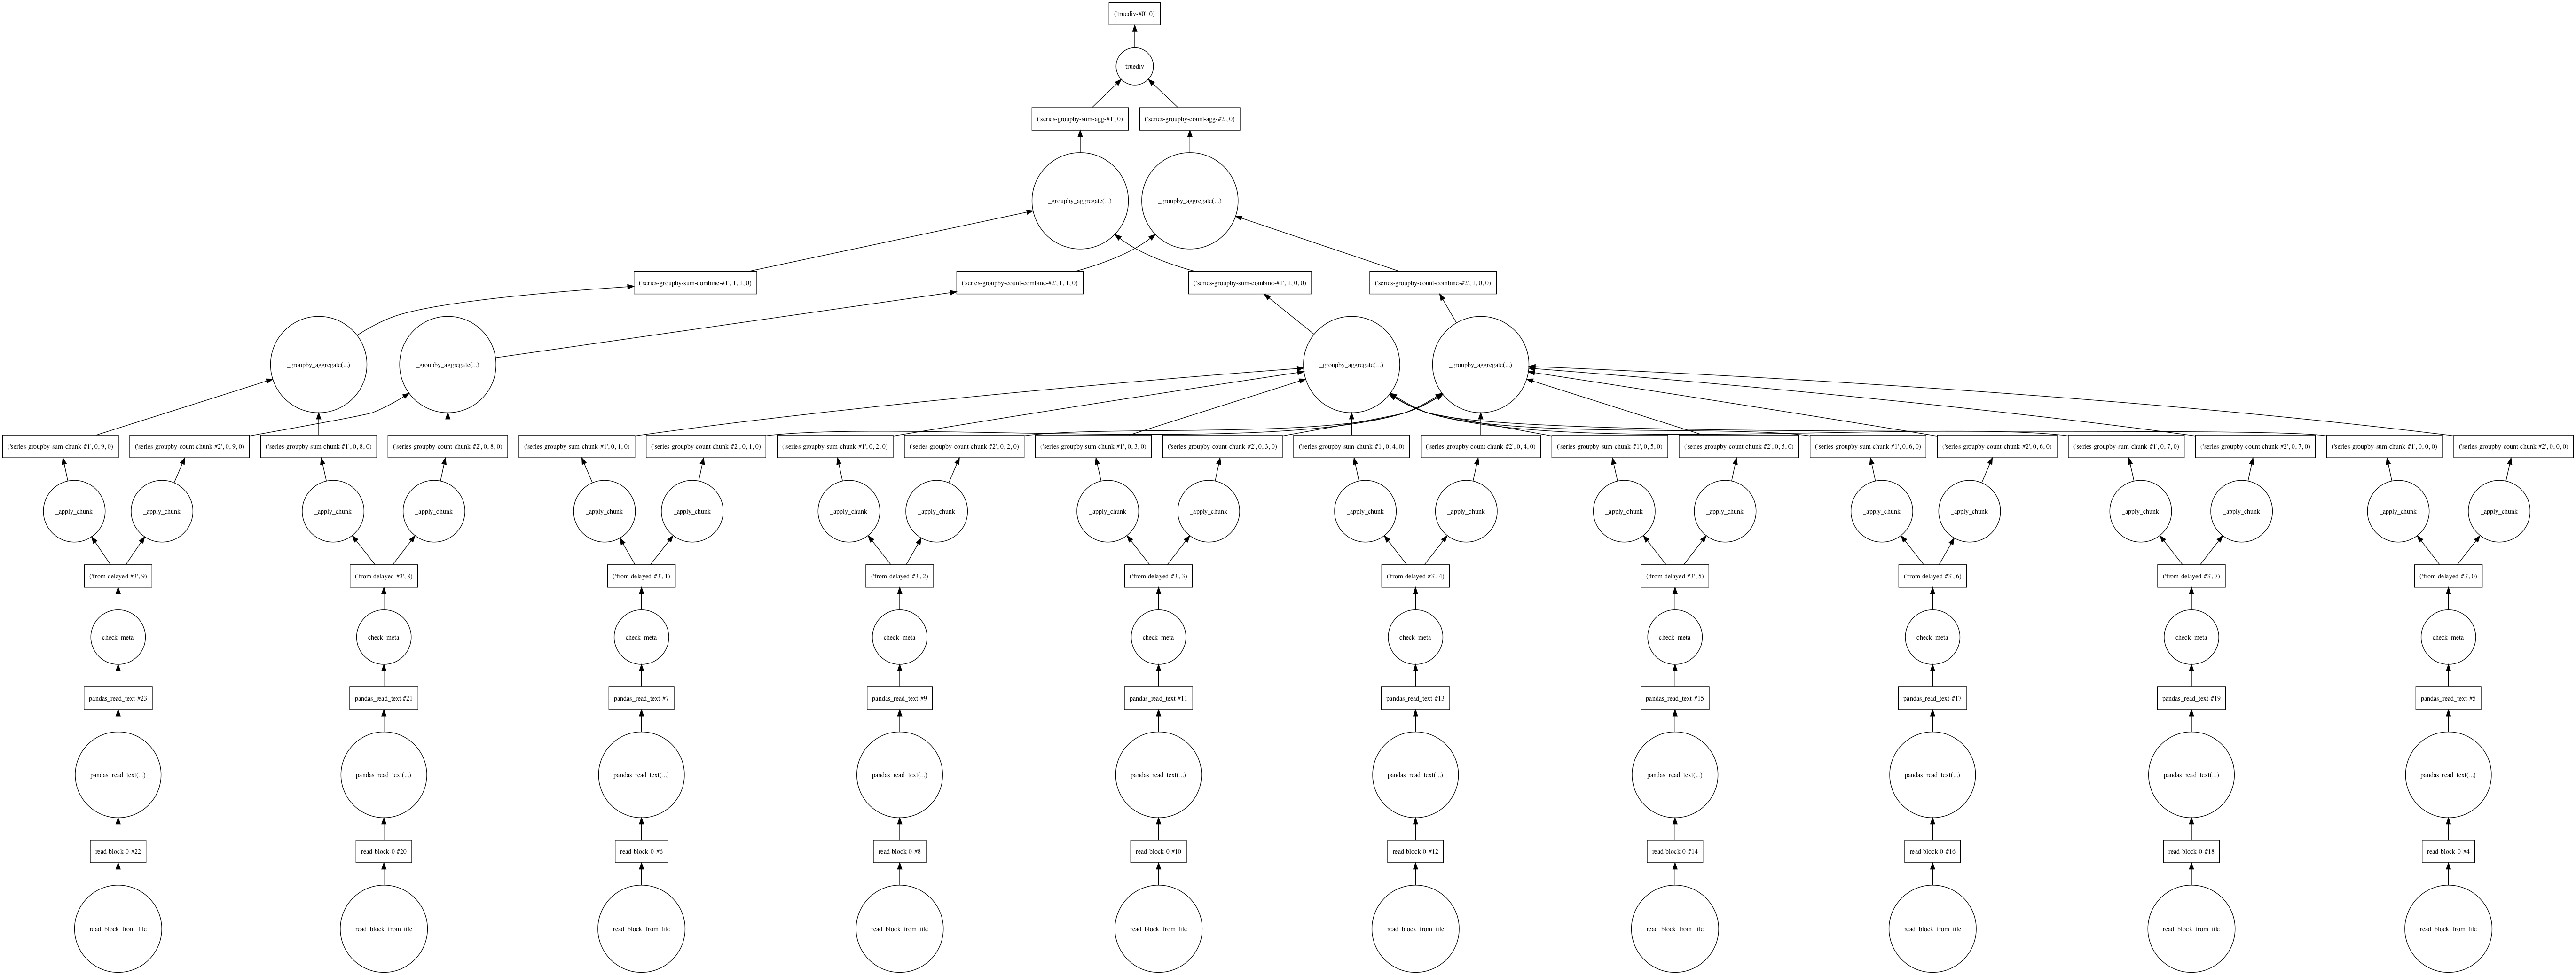

In [7]:
day_delay.visualize()

In [6]:
day_delay.compute()

DayOfWeek
1     8.096565
2     8.149109
3     9.141912
4    10.538275
5    11.476687
6     7.824071
7     8.994296
Name: DepDelay, dtype: float64

# But many problems aren't just big arrays and dataframes

The Python community writes clever algorithms

Fine Grained Python Code:

Cartesian product $R = A \times B$ where $r_{i,j}$ is a function of $i$ and $j$

In [ ]:
# EXAMPLE - do not execute
results = {}

for a in A:
    for b in B:
        if a < b:
            results[a, b] = f(a, b)
        else:
            results[a, b] = g(a, b)

## Parallelizable, but not a list, dataframe, or array

In [ ]:
# EXAMPLE - do not execute
from dask import delayed, compute

results = {}

for a in A:
    for b in B:
        if a < b:
            results[a, b] = delayed(f)(a, b)  # lazily construct graph
        else:
            results[a, b] = delayed(g)(a, b)  # without structure

In [ ]:
# EXAMPLE - do not execute
from dask import delayed, compute

results = {}

f = delayed(f)
g = delayed(g)

for a in A:
    for b in B:
        if a < b:
            results[a, b] = f(a, b)  # lazily construct graph
        else:
            results[a, b] = g(a, b)  # without structure

In [ ]:
# EXAMPLE - do not execute
final = compute(results)  # trigger all computation

## `concurrent.futures.ThreadPoolExecutor`

In [ ]:
# EXAMPLE - do not execute
from concurrent.futures import ThreadPoolExecutor 

e = ThreadPoolExecutor()

results = {}

for a in A:
    for b in B:
        if a < b:
            results[a, b] = e.submit(f, a, b)  # submit work asynchronously
        else:
            results[a, b] = e.submit(g, a, b)  # submit work asynchronously

In [ ]:
# EXAMPLE - do not execute
results = {k: v.result() for k, v in results.items()} # block until finished

# Dask APIs Produce Task Graphs

---
# Dask Schedulers Execute Task Graphs

## Exercise 2.1 `dask.delayed`

Implement the Cartesian cross product above using Numpy `array` objects for `A` and `B`, both with and without `dask.delayed` wrappers, and compare the performance.  Template code is provided below.

5 minutes

**BONUS:** Experiment with the `concurrent.futures.ThreadPoolExecutor` version

In [8]:
import numpy as np
from   time import sleep
A = np.random.randint(low=1, high=10, size=(50,))  # [1, 9]
B = np.random.randint(low=4, high=13, size=(25,))   # [4,12]

# the point is that f() and g() may perform some non-trivial operation
# but that each f() and g() is independent from every other invocation

def f(s, t):
    sleep(0.02)  # simulate computational complexity
    return s - t

def g(s, t):
    sleep(0.03)  # simulate computational complexity
    return s * t

## Predict Execution Time for Serial Compute

How long would you expect this to take on your computer? (rough estimate)

**Challenge:** Run the cell below and see if you can guess before it completes.

Remember that it isn't vectorized and there is no automatic parallelism.

In [9]:
%%time
results = {}

for a in A:
    for b in B:
        if a < b:
            results[a, b] = f(a, b) # 50 as and 25 bs = 1250 a x b 
        else:
            results[a, b] = g(a, b) # a=[1,9] b=[4, 12]

CPU times: user 2.64 s, sys: 472 ms, total: 3.11 s
Wall time: 33.5 s


In [10]:
list(results.items())[:40:3]

[((5, 10), -5),
 ((5, 4), 20),
 ((5, 6), -1),
 ((7, 8), -1),
 ((7, 5), 35),
 ((7, 12), -5),
 ((8, 7), 56),
 ((8, 9), -1),
 ((6, 10), -4),
 ((6, 4), 24),
 ((6, 6), 36),
 ((1, 8), -7),
 ((1, 5), -4),
 ((1, 12), -11)]

In [11]:
# How many results do you expect there to be?
len(results)

72

## Predict Execution Time for Perfect Parallelism

Imagine every `f()` and `g()` were 100% independent, with no communication overhead.

How long would you expect it to take on your computer?

In [12]:
%%time
from dask import delayed, compute

results = {}

for a in A:
    for b in B:
        if a < b:
            results[a, b] = delayed(f)(a, b)  # lazily construct graph
        else:
            results[a, b] = delayed(g)(a, b)  # without structure

CPU times: user 88.1 ms, sys: 14 ms, total: 102 ms
Wall time: 99.6 ms


In [13]:
list(results.items())[:40:3]

[((5, 10), Delayed('f-5566d995-a933-4d79-a189-8cfa32527d72')),
 ((5, 4), Delayed('g-ac94ee9c-692f-431a-b531-02ec82bee20a')),
 ((5, 6), Delayed('f-1fb85cb0-73e0-4174-b87b-314892cff408')),
 ((7, 8), Delayed('f-156df4d3-0d87-4f1d-9c9a-fec566f251f0')),
 ((7, 5), Delayed('g-3ede4fd2-5729-4e84-97f0-76d23d419dfd')),
 ((7, 12), Delayed('f-e06f2986-454e-4e65-aa03-7099bf2d6fc1')),
 ((8, 7), Delayed('g-4761788a-9c22-464d-987c-0d737c078645')),
 ((8, 9), Delayed('f-589f1fc5-f990-44d3-a53c-87b955cda67a')),
 ((6, 10), Delayed('f-fd519c1f-5eb7-4abb-a686-6504173c7aba')),
 ((6, 4), Delayed('g-fa99fa96-5d9f-4488-8e90-da5432459a69')),
 ((6, 6), Delayed('g-33ae21f7-9bc3-4f17-8a2e-7a82266a668b')),
 ((1, 8), Delayed('f-ea69aa20-fda4-4a14-b1de-91a76081ec05')),
 ((1, 5), Delayed('f-bbfa42d3-a4ac-40fc-b428-37fb34f1016b')),
 ((1, 12), Delayed('f-91a7b00a-5741-4de6-b274-e10f9a75ecae'))]

In [14]:
len(results)

72

In [15]:
its      = 72    # number of iterations len(A) * len(B)
cpus     = 8    # check your system stats
exectime = 0.025 # whatever the per-function delay is.

estimate = its * exectime / cpus
print(estimate)

0.225


In [16]:
%%time
final = compute(results)

CPU times: user 218 ms, sys: 25.6 ms, total: 244 ms
Wall time: 344 ms


In [17]:
list(final[0].items())[:40:3]

[((5, 10), -5),
 ((5, 4), 20),
 ((5, 6), -1),
 ((7, 8), -1),
 ((7, 5), 35),
 ((7, 12), -5),
 ((8, 7), 56),
 ((8, 9), -1),
 ((6, 10), -4),
 ((6, 4), 24),
 ((6, 6), 36),
 ((1, 8), -7),
 ((1, 5), -4),
 ((1, 12), -11)]

# Dask functions and data structures use `delayed()` internally

## 1D-Array

<img src="images/array-1d.svg">

    >>> np.ones((15,))
    array([ 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

    >>> x = da.ones((15,), chunks=(5,))

### 1D-Array

<img src="images/array-1d-sum.svg" width="30%">

In [18]:
import numpy      as np
import dask.array as da

In [19]:
x = da.ones((15,), chunks=(5,))
x.sum()

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=()>

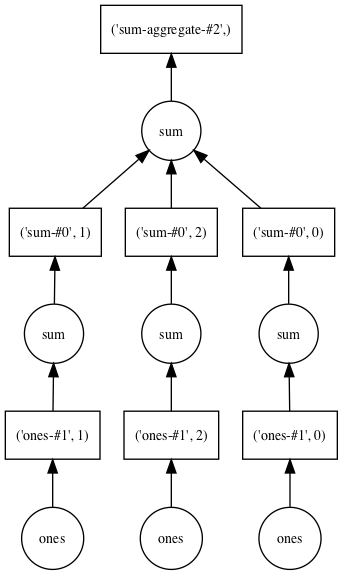

In [20]:
x.sum().visualize()

## ND-Array - Sum

<img src="images/array-sum.svg">

In [21]:
x = da.ones((15, 15), chunks=(5, 5))
x.sum(axis=0)

dask.array<sum-aggregate, shape=(15,), dtype=float64, chunksize=(5,)>

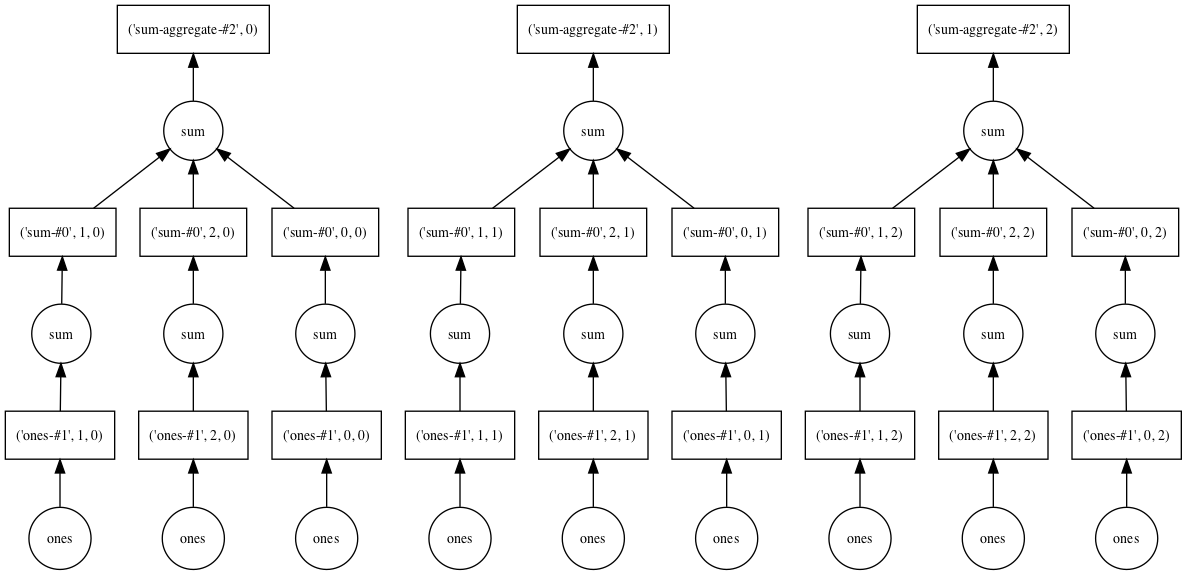

In [22]:
x.sum(axis=0).visualize()

In [23]:
x.sum(axis=0).compute()

array([15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15.])

### ND-Array - Transpose

<img src="images/array-xxT.svg">

In [24]:
x = da.random.randint(low=1, high=10, size=(15, 15), chunks=(5, 5))
y = x + x.T

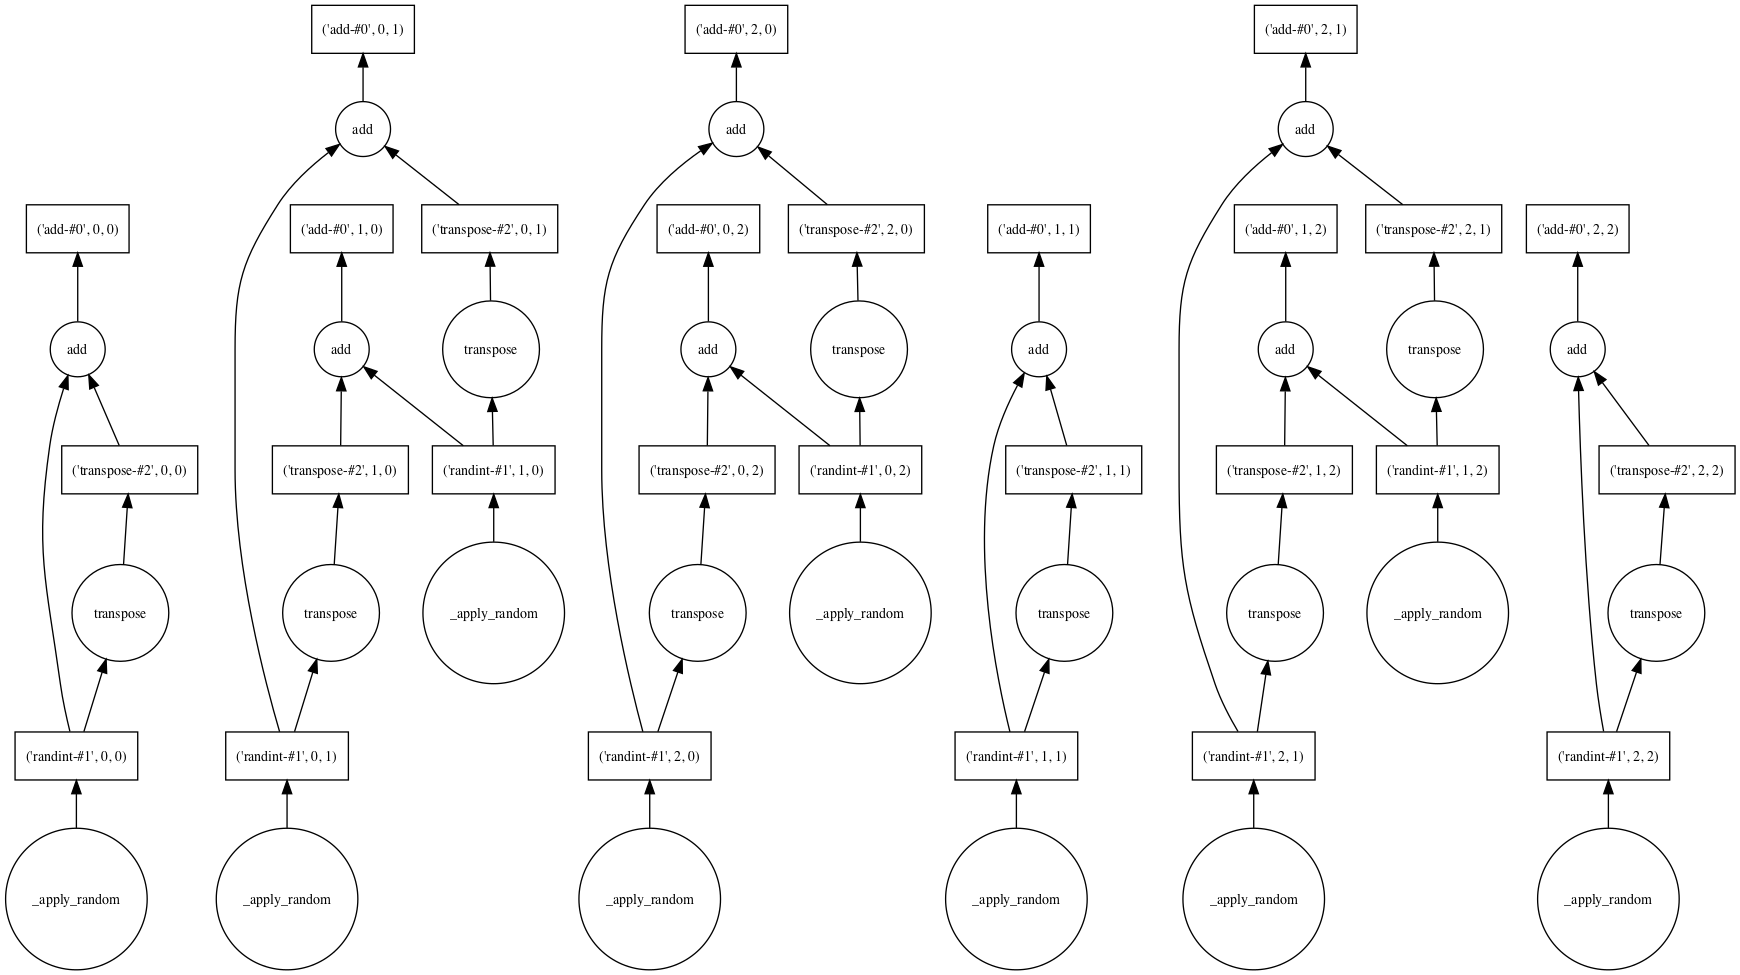

In [25]:
y.visualize()

In [26]:
y

dask.array<add, shape=(15, 15), dtype=int64, chunksize=(5, 5)>

In [27]:
y.compute()

array([[12,  9,  6, 11,  2, 11, 13, 12, 14, 12,  6, 12, 11, 15,  7],
       [ 9, 18, 15, 14,  8,  8,  7, 10,  4,  7, 16,  8,  7, 14, 13],
       [ 6, 15,  2, 11, 16,  6, 14,  9,  4, 10, 10, 15, 14, 16,  7],
       [11, 14, 11,  8, 12,  7, 11, 12,  3, 11,  8,  5,  9, 13,  9],
       [ 2,  8, 16, 12,  2, 15,  3, 11, 11, 13,  9,  4,  8,  9,  6],
       [11,  8,  6,  7, 15,  2, 10, 10,  6, 15, 12,  7, 16,  5,  6],
       [13,  7, 14, 11,  3, 10, 18, 14, 15, 12,  7,  3, 11, 10,  8],
       [12, 10,  9, 12, 11, 10, 14,  2, 16, 15,  7,  6, 10, 14,  7],
       [14,  4,  4,  3, 11,  6, 15, 16,  6,  8, 12, 11, 12, 16, 10],
       [12,  7, 10, 11, 13, 15, 12, 15,  8, 10,  8, 11, 15, 10,  9],
       [ 6, 16, 10,  8,  9, 12,  7,  7, 12,  8, 16,  3, 13,  4,  5],
       [12,  8, 15,  5,  4,  7,  3,  6, 11, 11,  3,  8, 14,  9,  6],
       [11,  7, 14,  9,  8, 16, 11, 10, 12, 15, 13, 14, 12, 13, 10],
       [15, 14, 16, 13,  9,  5, 10, 14, 16, 10,  4,  9, 13,  2,  7],
       [ 7, 13,  7,  9,  6,  6,  8

### ND-Array - Matrix Multiply

<img src="images/array-xdotxT.svg">

In [28]:
x = da.random.randint(low=1, high=10, size=(15, 15), chunks=(5, 5))
y = x.dot(x.T + 1)

In [29]:
y

dask.array<sum-aggregate, shape=(15, 15), dtype=int64, chunksize=(5, 5)>

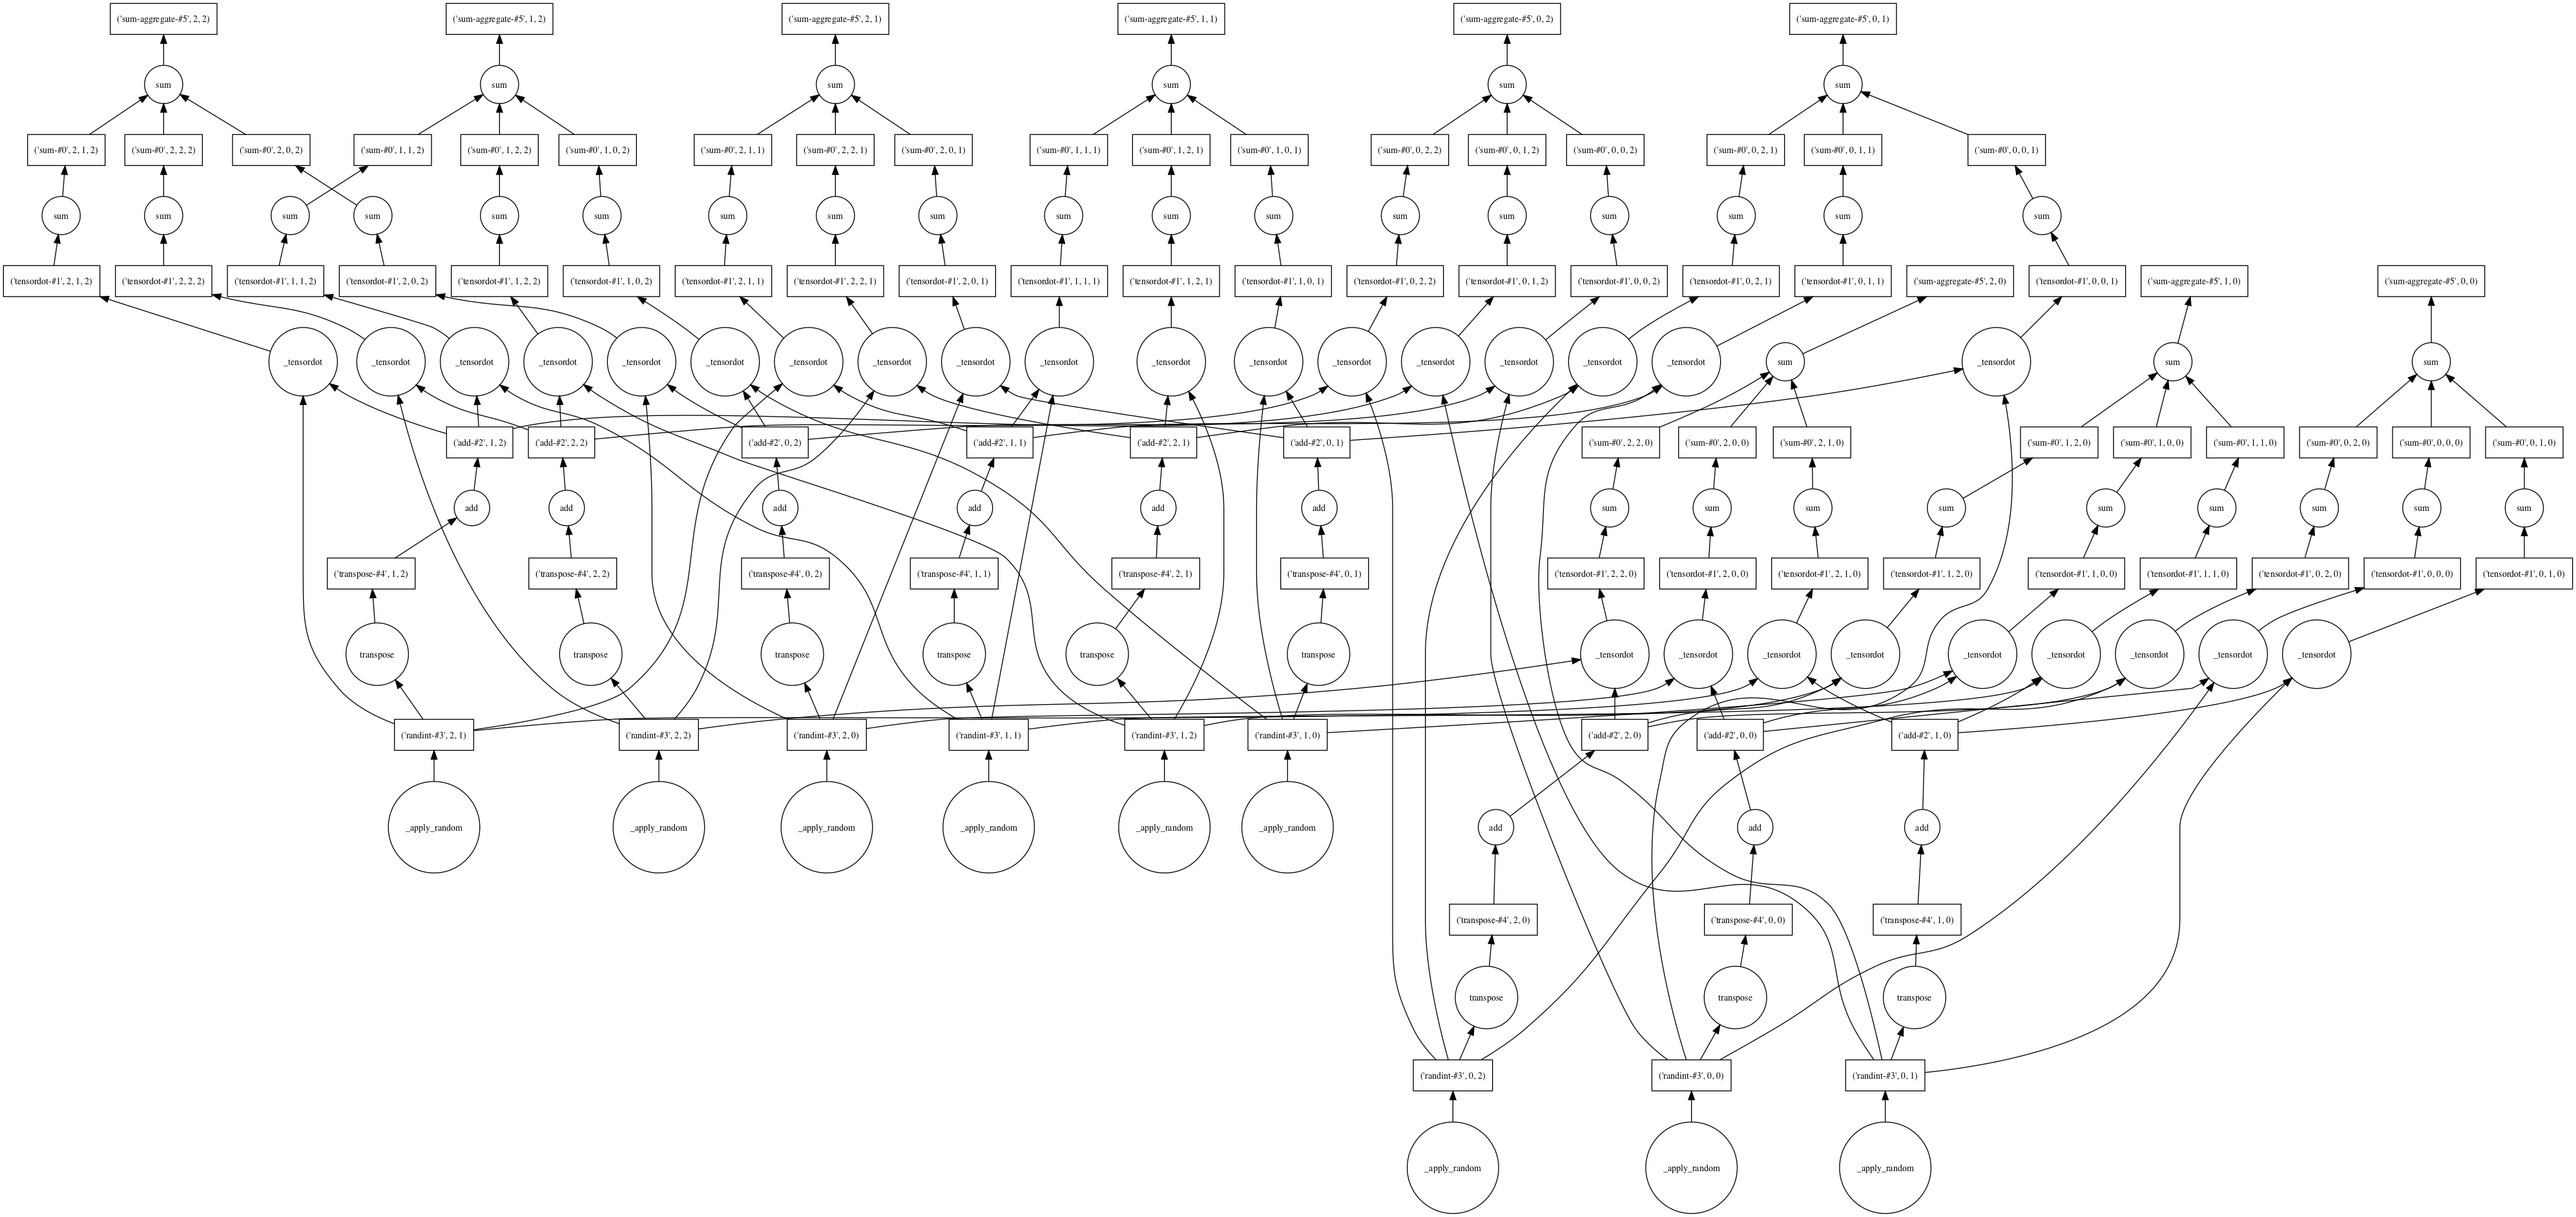

In [30]:
y.visualize()

In [32]:
y.compute()

array([[526, 428, 435, 462, 405, 467, 522, 390, 450, 348, 455, 498, 486,
        462, 398],
       [425, 512, 419, 458, 382, 456, 519, 372, 394, 297, 506, 467, 474,
        471, 391],
       [433, 420, 534, 455, 434, 494, 550, 358, 411, 308, 502, 494, 508,
        425, 310],
       [466, 465, 461, 616, 464, 508, 585, 405, 459, 385, 458, 478, 494,
        565, 461],
       [395, 375, 426, 450, 428, 451, 485, 307, 337, 318, 386, 405, 457,
        433, 334],
       [472, 464, 501, 509, 466, 582, 543, 370, 440, 358, 551, 460, 547,
        523, 419],
       [537, 537, 567, 596, 510, 553, 700, 439, 518, 405, 588, 606, 567,
        583, 446],
       [371, 356, 341, 382, 298, 346, 405, 382, 349, 227, 368, 386, 348,
        349, 263],
       [445, 392, 408, 450, 342, 430, 498, 363, 504, 319, 475, 450, 443,
        454, 374],
       [324, 276, 286, 357, 304, 329, 366, 222, 300, 314, 312, 289, 350,
        358, 303],
       [463, 517, 512, 462, 404, 554, 581, 395, 488, 344, 702, 500, 534,
       

## ND-Array - Compound Operations

<img src="images/array-xdotxT-mean.svg">

In [33]:
x = da.random.randint(low=1, high=10, size=(15, 15), chunks=(5, 5))
y = x.dot(x.T + 1) - x.mean()

In [34]:
y

dask.array<sub, shape=(15, 15), dtype=float64, chunksize=(5, 5)>

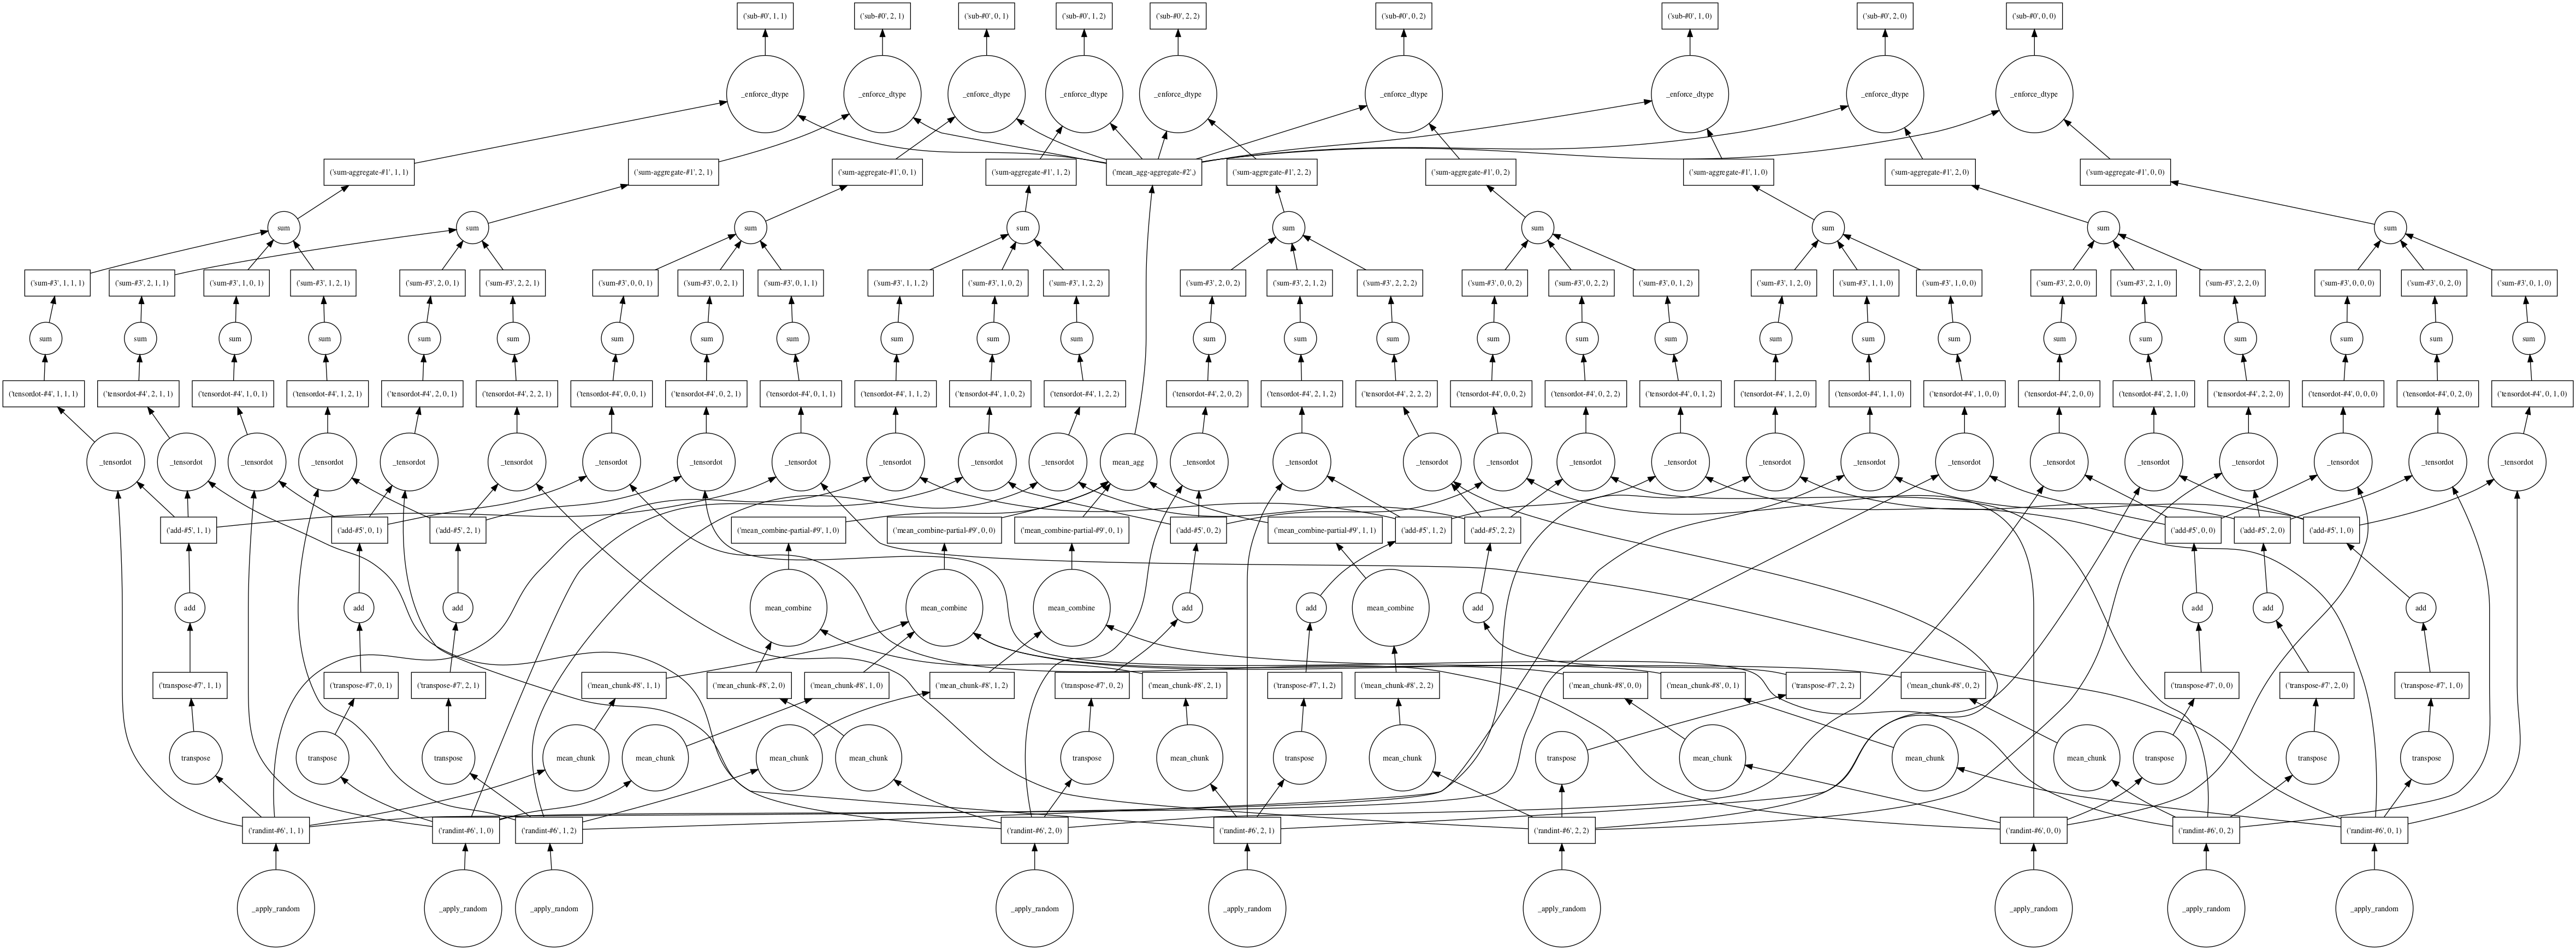

In [35]:
y.visualize()

In [36]:
y.compute()

array([[435.02222222, 342.02222222, 369.02222222, 456.02222222,
        445.02222222, 468.02222222, 352.02222222, 382.02222222,
        306.02222222, 345.02222222, 365.02222222, 388.02222222,
        280.02222222, 378.02222222, 453.02222222],
       [344.02222222, 425.02222222, 367.02222222, 456.02222222,
        441.02222222, 428.02222222, 361.02222222, 361.02222222,
        321.02222222, 375.02222222, 439.02222222, 389.02222222,
        378.02222222, 394.02222222, 459.02222222],
       [372.02222222, 368.02222222, 439.02222222, 480.02222222,
        420.02222222, 468.02222222, 347.02222222, 372.02222222,
        319.02222222, 358.02222222, 398.02222222, 442.02222222,
        358.02222222, 353.02222222, 462.02222222],
       [483.02222222, 481.02222222, 504.02222222, 729.02222222,
        567.02222222, 633.02222222, 462.02222222, 561.02222222,
        434.02222222, 491.02222222, 557.02222222, 553.02222222,
        437.02222222, 518.02222222, 649.02222222],
       [463.02222222, 457.02

## ND-Array - Compound Operations

<img src="images/array-xdotxT-mean-std.svg">

In [37]:
x = da.ones((15, 15), chunks=(5, 5))
y = (x.dot(x.T + 1) - x.mean()).std()

In [38]:
y

dask.array<sqrt, shape=(), dtype=float64, chunksize=()>

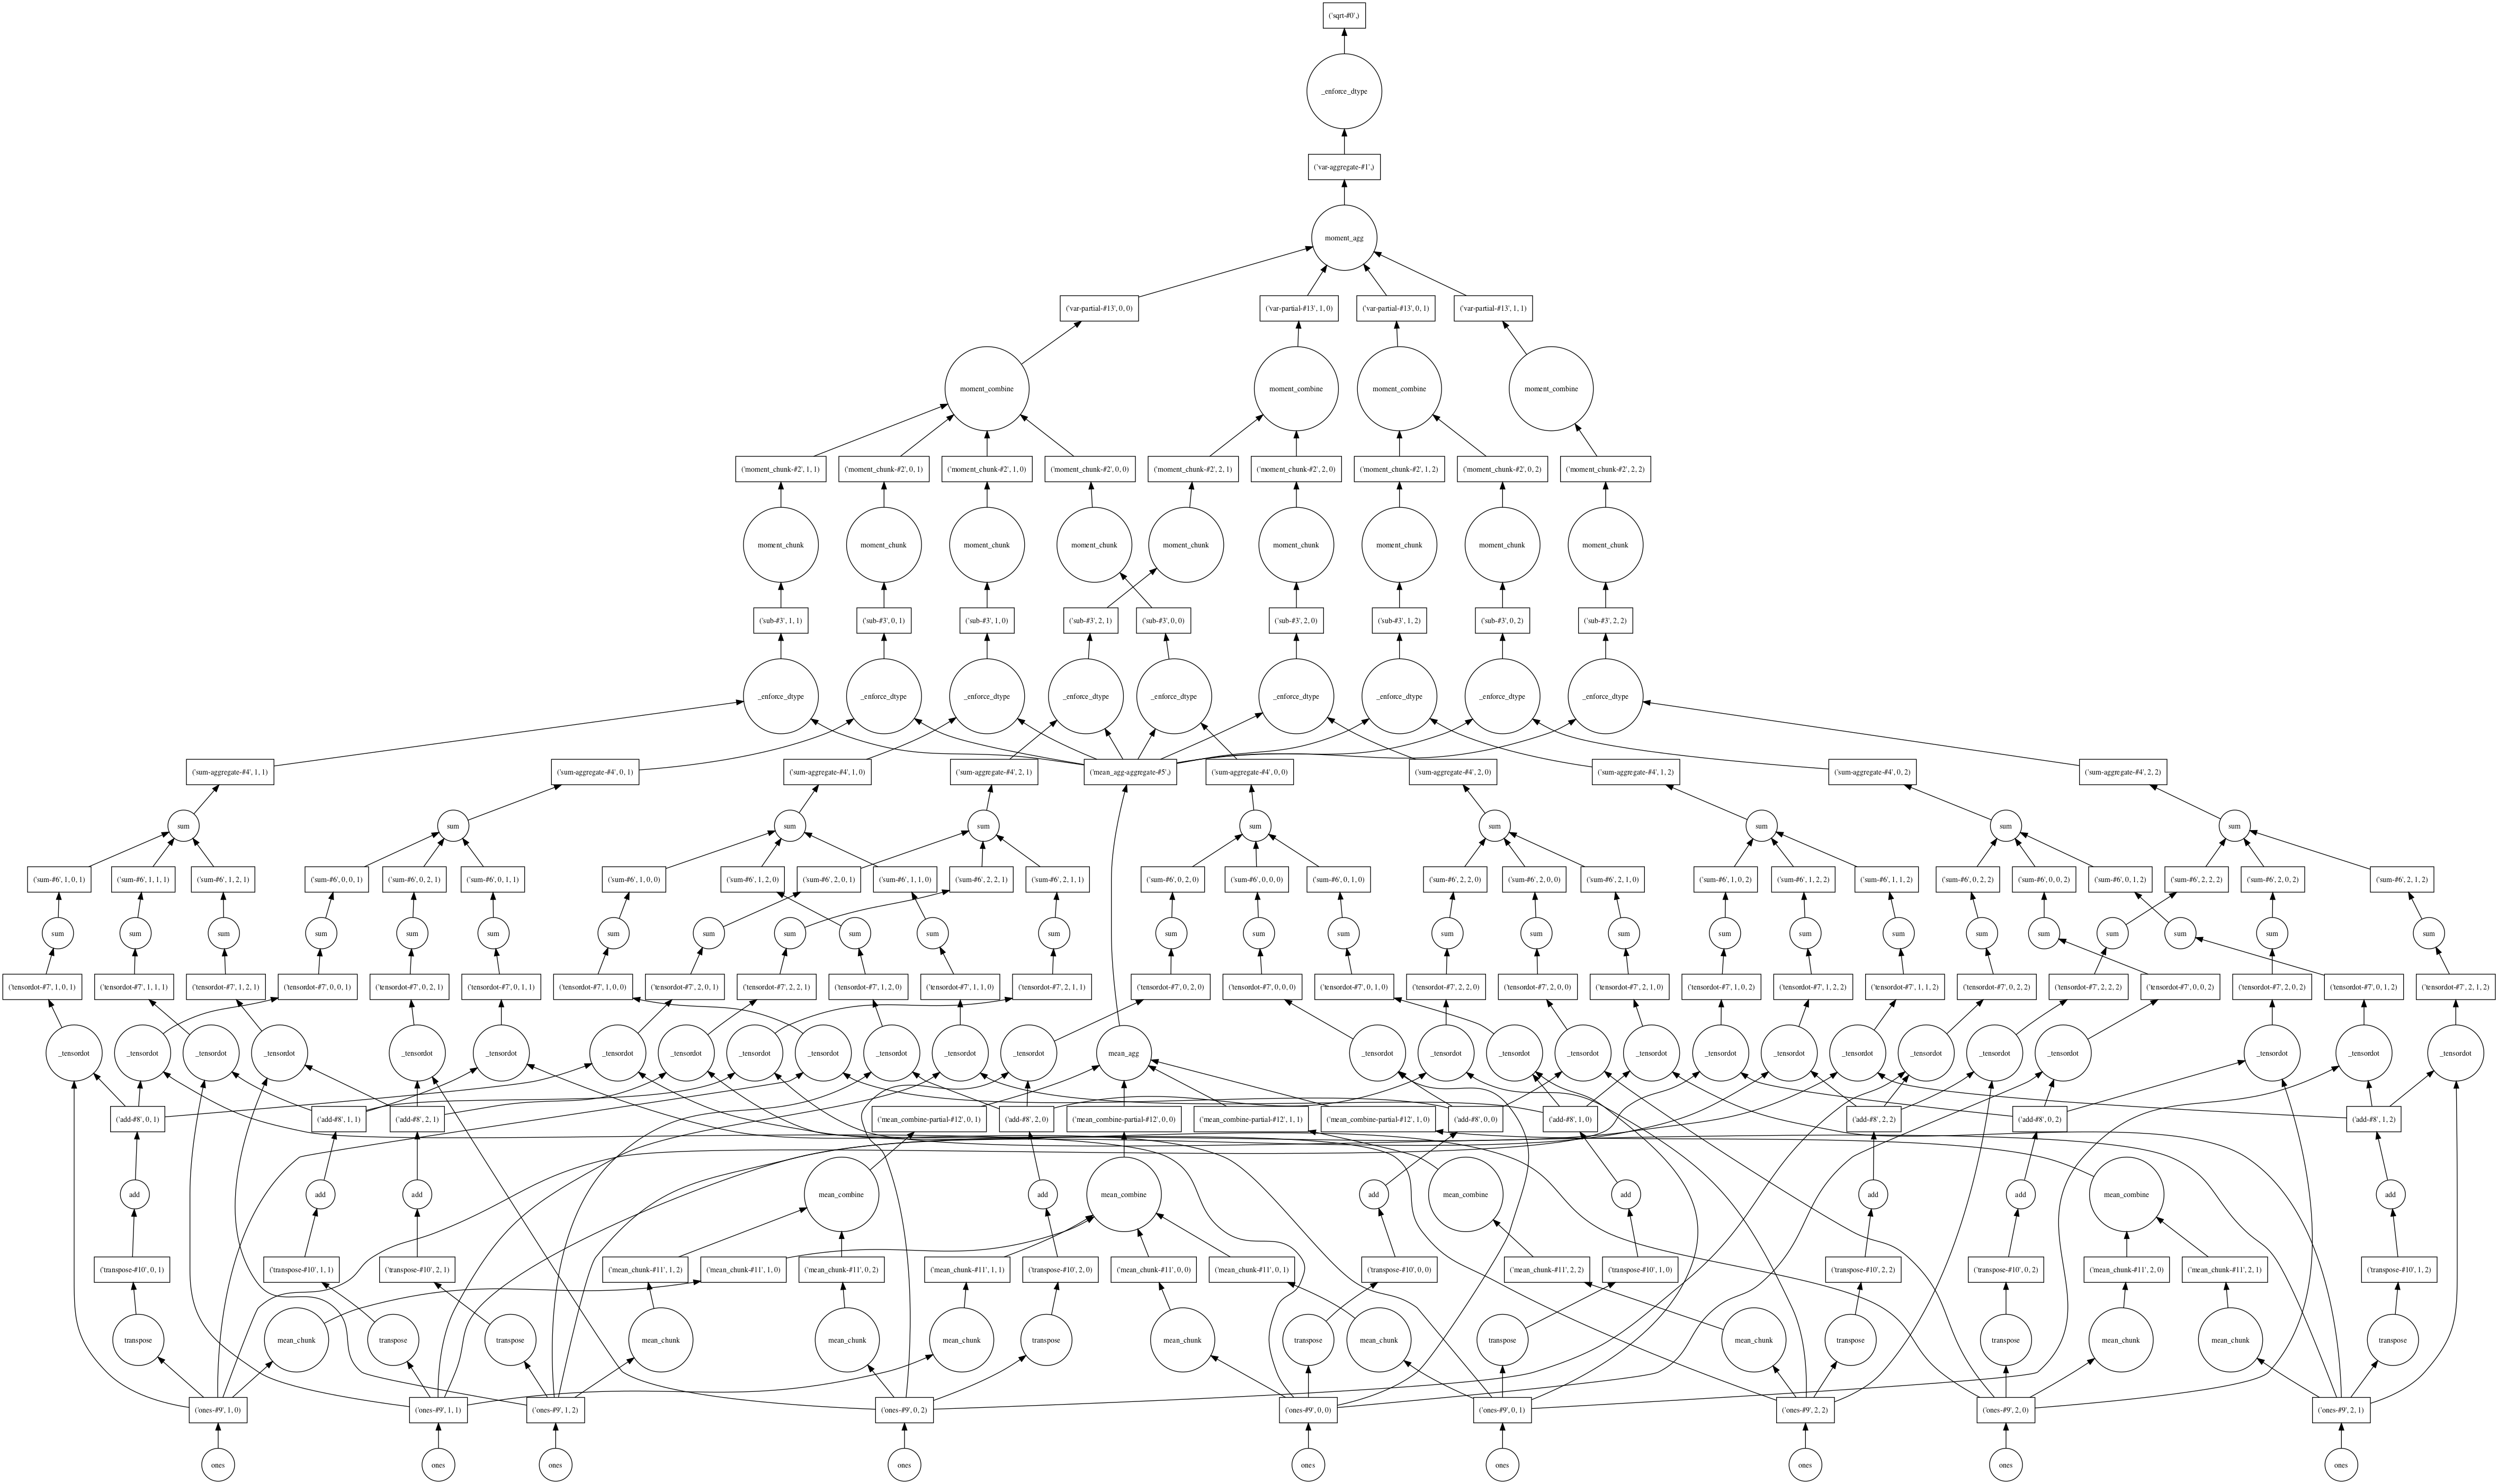

In [39]:
y.visualize()

In [40]:
y.compute() # I don't understand the result here, but linear algebra is not the main point ...

0.0

# Iterative Task Graph Construction

![xT](images/array-xxT.svg)

```python
x + x.T
```

![xT](images/array-xdotxT.svg)

```python
x.dot(x.T + 1)
```

![xT](images/array-xdotxT-mean.svg)

```python
x.dot(x.T + 1) - x.mean()
```

![xT](images/array-xdotxT-mean-std.svg)

```python
(x.dot(x.T + 1) - x.mean()).std()
```

# Dask APIs Produce Task Graphs

<hr>

# Dask Schedulers Execute Task Graphs

# Exercise 2.2 `dask.delayed` wrapper

In [41]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

* How many functions are called?
* How long does each one take?
* How long will the entire sequence take?
* Can you spot any opportunities for parallelism?

In [42]:
%%time
x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 236 ms, sys: 37.6 ms, total: 274 ms
Wall time: 3.01 s


### Parallelize with dask.delayed decorator

Those two increment calls *could* be called in parallel.

**ACTION:** Wrap `inc()` and `add()` with `dask.delayed`.  Then invoke the same sequence but using the wrapped versions of the functions.

This changes those functions so that they don't run immediately, but instead put those functions and arguments into a task graph.  Now when we run our code this runs immediately, but all it does it create a graph.  We then separately compute the result by calling the `.compute()` method.

## RESTART KERNEL HERE

In [1]:
# wrap each function
from dask import delayed, compute

from time import sleep

@delayed # identical to having AFTER def stmt "inc = delayed(inc)"
def inc(x):
    sleep(1)
    return x + 1

@delayed
def add(x, y):
    sleep(1)
    return x + y

In [2]:
%%time
x = inc(1)
y = inc(2)
z = add(x, y)
# invoke the same sequence for x, y, z using the wrapped functions

CPU times: user 491 µs, sys: 116 µs, total: 607 µs
Wall time: 530 µs


In [3]:
# inspect your result z -- how do you get the actual output?
z

Delayed('add-1e7bd8bf-e948-4466-ae7d-0a6afe4ef337')

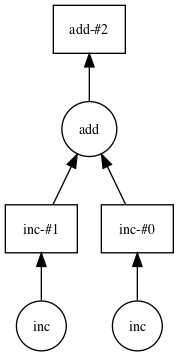

In [4]:
# visualize the task graph (if graphviz is working for you)
z.visualize()

In [5]:
%%time
z.compute()

CPU times: user 6.19 ms, sys: 3.61 ms, total: 9.8 ms
Wall time: 2.02 s


5

### What just happened?

The `z` object is a lazy `dask.Delayed` object.  This object holds everything we need to compute the final result.  We can compute the result with `.compute()` as above or we can visualize the result with `.visualize()`.

### Some questions to consider:

-  Why did we go from 3s to 2s?  Why weren't we able to parallelize down to 1s?
-  What would have happened if the inc and add functions didn't include the `sleep(1)`?  Would Dask still be able to speed up this code?
-  What if we have multiple outputs or also want to get access to x or y?

## Exercise 2.3 Parallelize a `for` loop

For loops are one of the most common things that we want to parallelize.  Use dask.delayed on `inc` and `sum` to parallelize the computation below:

In [6]:
data = list(range(20))

In [7]:
dsum = delayed(sum)

In [8]:
%%time
results = []
for x in data:
    y = inc(x)
    results.append(y)

CPU times: user 1.31 ms, sys: 671 µs, total: 1.98 ms
Wall time: 1.45 ms


In [9]:
%%time
total = dsum(results)

CPU times: user 264 µs, sys: 88 µs, total: 352 µs
Wall time: 350 µs


In [10]:
results

[Delayed('inc-256307bc-0371-47eb-a0ce-1dc96981b9f3'),
 Delayed('inc-c298a92c-dab7-4bc6-a913-1a287bf96042'),
 Delayed('inc-701624b4-64ee-4c1e-bb2f-df09946a3317'),
 Delayed('inc-f2d91b38-4a4c-4a9c-ba7d-0866e3a3e062'),
 Delayed('inc-0f7dd701-4570-4b18-8a38-4c5fd7847b64'),
 Delayed('inc-b82bc731-04cc-4989-9340-d002edb03846'),
 Delayed('inc-b7cd44e1-7d52-4c33-8a40-9e606ce3c6d6'),
 Delayed('inc-b14b5f6d-d000-451c-b6ff-f5a40a3a5fb2'),
 Delayed('inc-17bbb3f1-7358-4848-a457-516c1531fbc8'),
 Delayed('inc-2d843a23-cd8d-4b1e-b62d-5fb7ef98ff9f'),
 Delayed('inc-6cefc2c9-1a8b-41dc-9d6d-5a5752166828'),
 Delayed('inc-6a141256-a978-4c5e-9777-7d5c8eb3d9f5'),
 Delayed('inc-7e1458c3-34f0-463d-9f3d-7e07df99a486'),
 Delayed('inc-f5875cc3-e69e-4252-8cec-24eb20df4efb'),
 Delayed('inc-16cf84ff-a6dc-4335-8fc2-bd72d95e0ac7'),
 Delayed('inc-e1f9e9cb-973a-46bb-9ae7-e57a50d8db27'),
 Delayed('inc-f4eba79d-6e4c-48e1-a4f8-b406dae53fb9'),
 Delayed('inc-4536268f-88a0-4f15-8e7e-de8971fb5652'),
 Delayed('inc-2b24e907-0c2a-

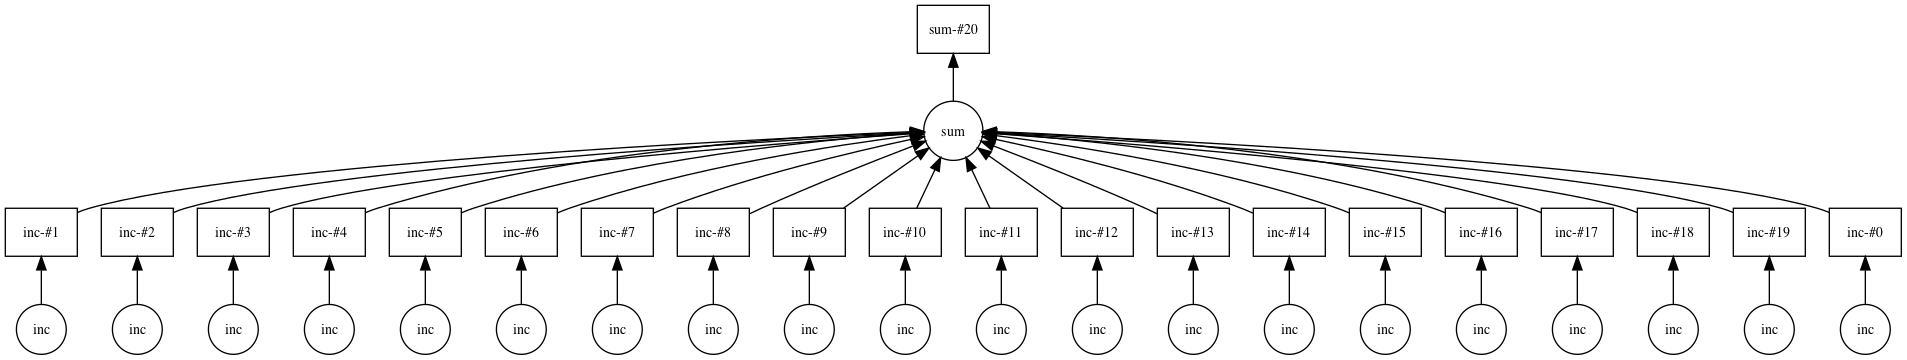

In [11]:
total.visualize()

In [12]:
%%time
# Parallel code

results = []
for x in data:
    # TODO
    pass

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


In [13]:
%%time
total.compute()

CPU times: user 7.09 ms, sys: 3.14 ms, total: 10.2 ms
Wall time: 3.01 s


210

### Parallelizing for-loop code with control flow

Often we want to delay only *some* functions, running a few of them immediately.  This is especially helpful when those functions are fast and help us to determine what other slower functions we should call.  This decision, to delay or not to delay, is usually where we need to be thoughtful when using dask.delayed.

In the example below we iterate through a list of inputs.  If that input is even then we want to call `inc`.  If the input is odd then we want to call `double`.  This `iseven` decision to call `inc` or `double` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [14]:
def double(x):
    sleep(1)
    return 2 * x

def iseven(x):
    return x % 2 == 0

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [15]:
%%time
# Sequential code

results = []
for x in data:
    if iseven(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
total

CPU times: user 5.73 ms, sys: 2 ms, total: 7.74 ms
Wall time: 5.01 s


In [16]:
%%time
# Parallel code
# TODO: parallelize the sequential code above using dask.delayed
# You will need to delay some functions, but not all

results = []
for x in data:
    if iseven(x):
        y = delayed(double)(x)
    else:
        y = delayed(inc)(x)
    results.append(y)

CPU times: user 1.22 ms, sys: 488 µs, total: 1.71 ms
Wall time: 1.36 ms


In [17]:
    
total = dsum(results)
total

Delayed('sum-b675e8e5-47d7-4527-87f2-26129e650747')

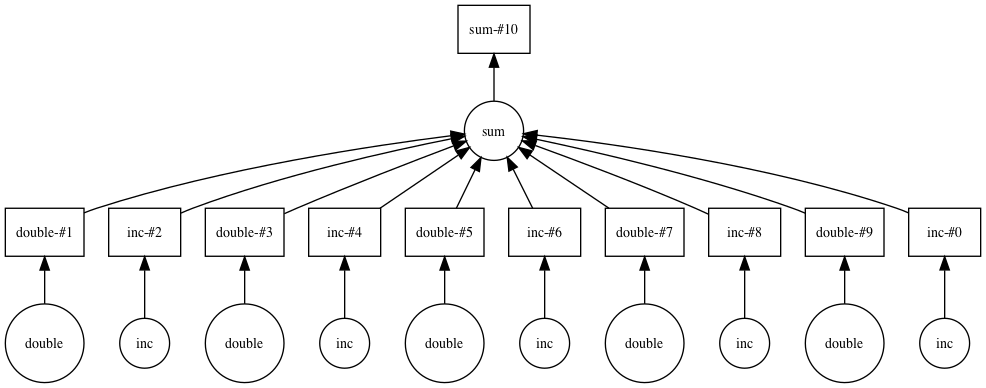

In [18]:
total.visualize()

In [19]:
%time total.compute()

CPU times: user 5.24 ms, sys: 3.06 ms, total: 8.3 ms
Wall time: 2.01 s


90

In [ ]:
### Solutions

In [20]:
# %load solutions/02-delayed-inc-double.py
# Parallel code

results = []
for x in data:
    if iseven(x):  # even
        y = dask.delayed(double)(x)
    else:          # odd
        y = dask.delayed(inc)(x)

    results.append(y)
    
total = dask.delayed(sum)(results)
total.compute()


### Some questions to consider:

-  What are other examples of control flow where we can't use delayed?
-  What would have happened if we had delayed the evaluation of `iseven(x)` in the example above?
-  What are your thoughts on delaying `sum`?  This function was both computational but also very fast to run.

## Exercise 2.4 Pandas and Dask

In this exercise we read several CSV files and perform a groupby operation in parallel.  We are given sequential code to do this and parallelize it with Dask.delayed.

The computation we will parallelize is to compute the daily high-low spread of a stock over time.  We will do this by using dask.delayed together with Pandas.  In a future section we will do this same exercise with dask.dataframes.

### Read one file with `pandas.read_csv` and compute spread

In [ ]:
import pandas as pd
df = pd.read_csv('data/minute/ibm/2010-01-04.csv', 
                 parse_dates=['timestamp'], 
                 index_col='timestamp')
df.head()

In [ ]:
spread = df.high.max() - df.low.min()
spread

### Sequential code: spread over time

This code performs the spread computation on every day of data using a sequential for loop.

In [ ]:
from glob import glob
filenames = sorted(glob('data/minute/ibm/*.csv'))

In [ ]:
%%time

spreads = []
days = []
for fn in filenames:
    df = pd.read_csv(fn, parse_dates=['timestamp'], index_col='timestamp')
    spread = df.high.max() - df.low.min()
    day = df.index[0].round('1d')
    
    spreads.append(spread)
    days.append(day)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 5))
plt.plot(days, spreads)

In [ ]:
%%time
from dask import dataframe as dd
df = dd.read_csv('data/minute/ibm/2010-01-0*.csv', parse_dates=['timestamp'])

In [ ]:
%%time
df.columns

In [ ]:
df

In [ ]:
%%time
spread = df.high - df.low 

In [ ]:
%%time
spread.compute()

### Parallelize the code above

Use `dask.delayed` to parallelize the code above.  Some extra things you will need to know.

1.  Methods and attribute access on delayed objects work automatically, so if you have a delayed object you can perform normal arithmetic, slicing, and method calls on it and it will produce the correct delayed calls.

    ```python
    x = delayed(np.arange)(10)
    y = (x + 1)[::2].sum()  # everything here was delayed
    ```
2.  Calling the `.compute()` method works well when you have a single output.  When you have multiple outputs you might want to use the `dask.compute` function:

    ```python
    >>> x = dask.delayed(np.arange)(10)
    >>> y = x ** 2
    >>> min, max = dask.compute(y.min(), y.max())
    (0, 81)
    ```
    
    This way dask can share the intermediate values (like `y = x**2`)
    
So your goal is to parallelize the code above (which has been copied below) using Dask.delayed.  You may also want to visualize a bit of the computation to see if you're doing it correctly.

*Note: performance will improve a little bit, but not a whole lot.  We'll discuss why afterwards*

In [ ]:
%%time

spreads = []
days = []
for fn in filenames:
    ...
    
spreads, days = dask.compute(spreads, days)

### Solutions

In [ ]:
import dask

In [ ]:
%load solutions/02-delayed-pandas.py

Now use `dask.dataframe.read_csv()` to perform the same operations